In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [3]:
a = 20 # prior: parameter a
b = 10 # prior: parameter b
n = 50 # likelihood: number of tosses
y = 10 # likelihood: number of HEADs
sigma = 0.1 # proposal standard deviation
theta_0 = 0.5 # a lucky guess...
N = 50_000 # chain length

In [4]:
prior_fun = lambda theta: stats.beta.pdf(theta, a, b)
lik_fun = lambda theta: (theta ** y) * (1 - theta)**(n-y)
unscaled_post_fun = lambda theta: prior_fun(theta)*lik_fun(theta)

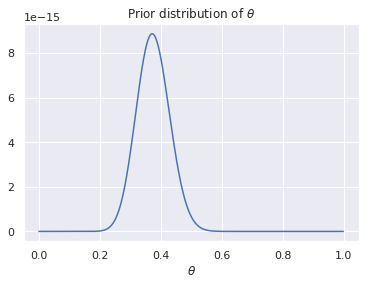

In [5]:
dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
plt.plot(theta_vec, unscaled_post_fun(theta_vec))
plt.xlabel(r"$\theta$");
plt.title(r"Prior distribution of $\theta$");

In [6]:
# Approach 1: compute the posterior in closed-form (if you can...)

exact_post_fun = lambda theta: stats.beta.pdf(theta, a+y, b+n-y) # exact posterior

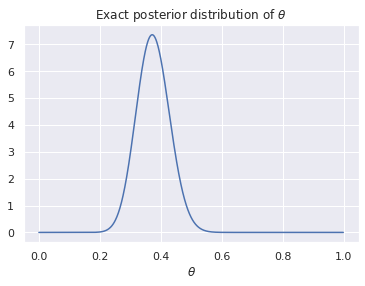

In [7]:
dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
plt.plot(theta_vec, exact_post_fun(theta_vec))
plt.xlabel(r"$\theta$");
plt.title(r"Exact posterior distribution of $\theta$");

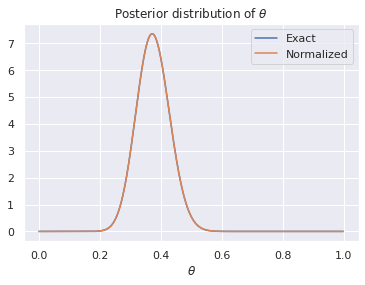

In [8]:
# Approach 2: compute normalization constant (easy in 1D, suffers curse of dimensionality...)

dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
normalization_constant = np.sum(unscaled_post_fun(theta_vec)) * dtheta
scaled_post_fun = lambda theta: unscaled_post_fun(theta)/normalization_constant

plt.plot(theta_vec, exact_post_fun(theta_vec), label="Exact")
plt.plot(theta_vec, scaled_post_fun(theta_vec), label="Normalized")
plt.xlabel(r"$\theta$");
plt.legend()
plt.title(r"Posterior distribution of $\theta$");

In [9]:
theta_step = theta_0
p_step = unscaled_post_fun(theta_step)
thetas = []

for idx in range(N):
    thetas.append(theta_step)
    theta_prop = theta_step + sigma*np.random.randn()
    p_prop = unscaled_post_fun(theta_prop) # evaluate unscaled distribution

    p_ratio = p_prop/p_step
    accept = p_ratio >= 1 # accept if p_prop > p_step
    accept =  accept or np.random.binomial(1, p_ratio) # accept w.p. ratio otherwise
    
    if accept:
        theta_step = theta_prop
        p_step = p_prop

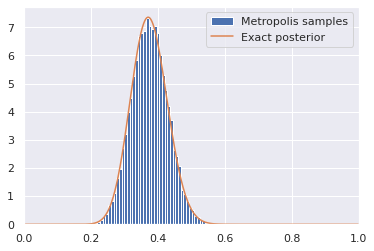

In [10]:
plt.hist(thetas, density=True, bins=50, label="Metropolis samples")
plt.plot(theta_vec, exact_post_fun(theta_vec), label="Exact posterior")
plt.legend()
plt.xlim([0, 1]);

In [11]:
theta_step = theta_0
p_step = unscaled_post_fun(theta_step)
thetas = []

for idx in range(N):
    thetas.append(theta_step)
    theta_prop = theta_step + sigma*np.random.randn()
    p_prop = unscaled_post_fun(theta_prop) # evaluate unscaled distribution

    p_ratio = p_prop/p_step
    accept = p_ratio >= 1 # accept if p_prop > p_step
    accept =  accept or np.random.binomial(1, p_ratio) # accept w.p. ratio otherwise
    
    if accept:
        theta_step = theta_prop
        p_step = p_prop

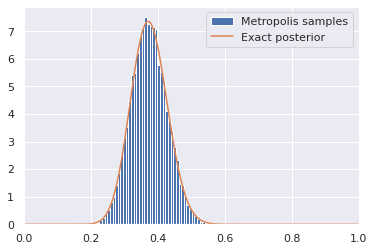

In [12]:
plt.hist(thetas, density=True, bins=50, label="Metropolis samples")
plt.plot(theta_vec, exact_post_fun(theta_vec), label="Exact posterior")
plt.legend()
plt.xlim([0, 1]);